# Identificação e Validação do modelo linear das taxas

Os dados de entrada correspondem à resposta em frequência obtidos com o script `analise_resposta_em_freq.ipynb`.
Será analisada a taxa `p` variação do ângulo de rolagem.

* TODO: Reduzir a amsotra oara a validaçãodo modelo.
* TODO: Utilizar mínimos quadrados para ajustar os parâmetros do compensador no domínio do tempo.
* TODO: Avaliar a sensiblidade do modelo aos parâmetros.

In [17]:
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')  # Configurar o backend para TkAgg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid, quad
from myfunctions import read_ulog, list_all_fields, get_ulog_data, butter_lowpass_filter, rk4
from numpy.random import uniform

In [2]:
# Carrega os dados de 'dados/freq_rad_p_rate.txt'
df_freq = pd.read_csv('dados/freq_rad_s_p_rate.txt')
freq_rad = df_freq.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/modulo_dB_p_rate.txt'
df_modulo = pd.read_csv('dados/modulo_dB_p_rate.txt')
modulo_dB = df_modulo.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/fase_rad_p_rate.txt'
df_fase = pd.read_csv('dados/fase_rad_p_rate.txt')
fase_deg = df_fase.iloc[:, 0].astype(float)

# Modelo da dinâmica da taxa p
$$
\dfrac{P(s)}{U(s)}=ke^{-\tau s}\left(\dfrac{Ts+1}{a T s+1}\right)\left(\dfrac{1}{I_{xx}s}\right), ~~~0<a<1.
$$

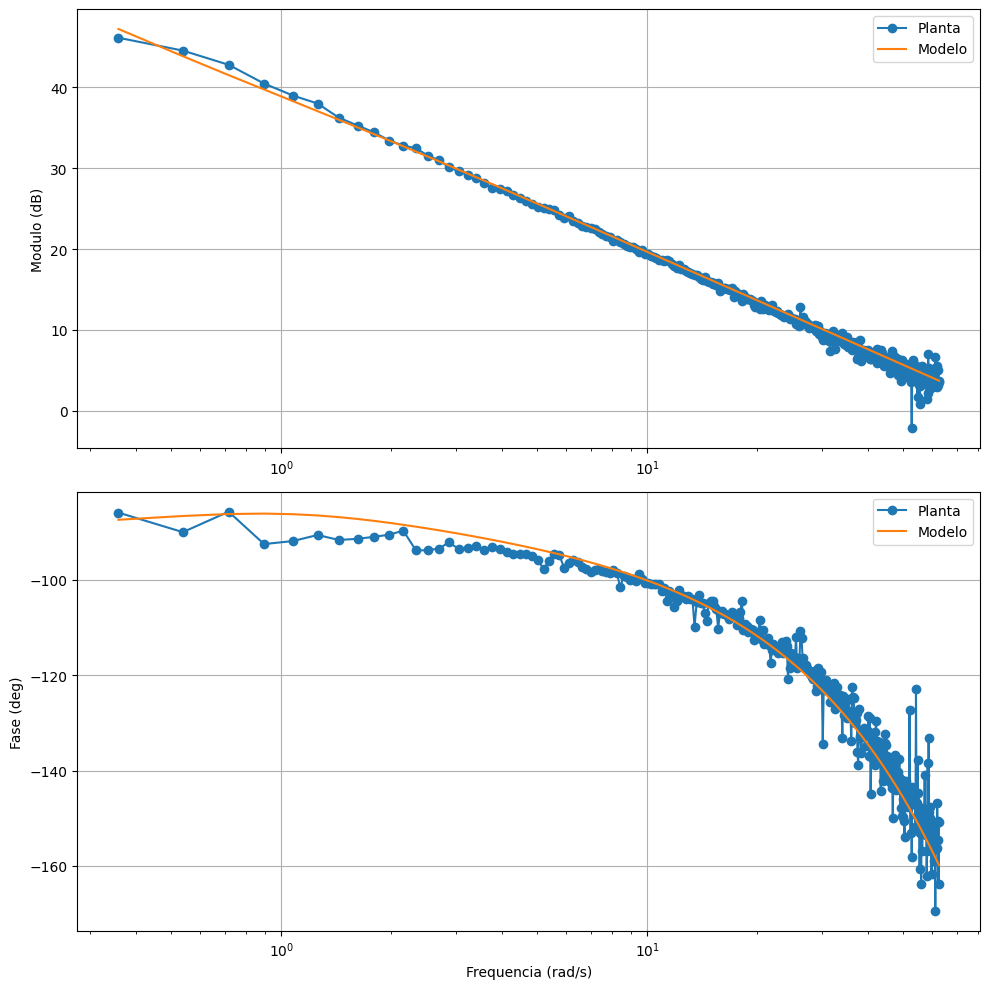

In [3]:
# Parâmetros do modelo com compensador
Ixx = 0.016 # Momento de inercia
tau = 0.0195 # Atraso de tempo

# Parâmetros do modelo sem compensador
#Ixx = 0.01 # Momento de inercia
#tau = 0.018 # Atraso de tempo


# Projeto do compensador
fm = 1.7e-1    # Frequencia média em Hz
Gc = 3    # Ganho do compensador em dB
phim = 5.0 # Avanço de fase em graus na frequencia média
#
def calcula_param_comp(fm, Gc, phim):
    a = (1-np.sin(phim*np.pi/180))/(1+np.sin(phim*np.pi/180))
    T = 1/(fm*2*np.pi*np.sqrt(a))
    k = 10**(Gc/20)*np.sqrt(a)
    return a, T, k 

a, T, k = calcula_param_comp(fm, Gc, phim)

def dyn_p(w):
    s = complex(0,w)
    return 1 / (Ixx*s)

def delay_p(w):
    s = complex(0,w)
    return np.exp(-tau*s)

def compensador(w):
    s = complex(0,w)
    return k*(T*s + 1)/(a*T*s + 1)

# Modelo do sistema com compensador
tf = lambda w: dyn_p(w)*delay_p(w)*compensador(w) 
# Modelo do sistema sem compensador
#tf = lambda w: dyn_p(w)*delay_p(w)

# Calcula a resposta em frequência de tf
mod_tf_dB = np.zeros(len(freq_rad))
tf_fase = np.zeros(len(freq_rad))
for i in range(len(freq_rad)):
    mod_tf_dB[i] = 20*np.log10(abs(tf(freq_rad[i])))
    tf_fase[i] = np.angle(tf(freq_rad[i]))*180/np.pi

# Gráfico de Bode
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.semilogx(freq_rad, modulo_dB, label='Planta', marker='o')
ax1.semilogx(freq_rad, mod_tf_dB, label='Modelo')
ax1.grid()
ax1.set_ylabel('Modulo (dB)')
ax1.legend()
ax2.semilogx(freq_rad, fase_deg, label='Planta', marker='o')
ax2.semilogx(freq_rad, np.unwrap(tf_fase), label='Modelo')
ax2.grid()
ax2.set_ylabel('Fase (deg)')
ax2.set_xlabel('Frequencia (rad/s)')
ax2.legend()
plt.tight_layout()
plt.show()

# Análise do modelo linear

O modelo linear identificado para $P(s)$ é:
$$
\dfrac{P(s)}{U(s)}=ke^{-\tau s}\left(\dfrac{Ts+1}{a T s+1}\right)\left(\dfrac{1}{I_{xx}s}\right), ~~~0<a<1.
$$
com $I_{xx}$, $\tau$, $k,~T$ e $a$ como parâmetros livres para otimização. Assim, temos: 
$$
s(a T s+1)P(s)=\dfrac{k}{I_{xx}}e^{-\tau s}(Ts+1)U(s)
$$
$$
s \left(s+\dfrac{1}{aT}\right)P(s)=\dfrac{k}{aI_{xx}}e^{-\tau s}\left(s+\dfrac{1}{T}\right)U(s)
$$
$$
s^2P(s)+\dfrac{1}{aT}sP(s)=\dfrac{k}{aI_{xx}}e^{-\tau s}\left(sU(s)+\dfrac{1}{T}U(s)\right).
$$
Aplicando Transformada Inversa de Laplace, obtemos:
$$
\ddot{p}(t)+\dfrac{1}{aT}\dot{p}(t)=\dfrac{k}{aI_{xx}}(\dot{u}(t-\tau)+\dfrac{1}{T}u(t-\tau)).
$$
Escolhendo como variáveis de estado $x_1(t)=p(t)$ e $x_2(t)=\dot{p}(t)$, temos;
$$
\begin{align*}
\dot{x}_1&=x_2\\
\dot{x}_2&=-\dfrac{1}{aT}x_2+\hat{u},
\end{align*}
$$
onde $\hat{u}(t):=\dfrac{k}{aI_{xx}}(\dot{u}(t-\tau)+\dfrac{1}{T}u(t-\tau))$.

Sem o compensador, teriamos apenas:
$$
\dot{p}(t)=\dfrac{1}{I_{xx}}u(t-\tau).
$$

# Validação do modelo no domínio do tempo
**Objetivo**: Ajustar os parâmetros do modelo utilizando mínimos quadrados com os dados de referência. Para isso utlizamos um sinal de entrada diferente do utilizado para obter a responta em frequência.
Precisamos dos dados:
1. Carregar de arquivo,
2. Filtrar os dados,
3. Recortar os dados.

In [4]:
# Para esse test utilizamos o seguinte conjunto de dados
file_path = 'ulogs/log_1_2024-9-3-07-56-31.ulg' # double sawtooth signal 0k! Tem poucos harmônicos
# Ler o arquivo .ulg
ulog = read_ulog(file_path)

In [5]:
# Coletar os dados dos atuadores
timestamps_c0, control0 = get_ulog_data(ulog, 'actuator_motors', 'control[0]')
timestamps_c1, control1 = get_ulog_data(ulog, 'actuator_motors', 'control[1]')
timestamps_c2, control2 = get_ulog_data(ulog, 'actuator_motors', 'control[2]')
timestamps_c3, control3 = get_ulog_data(ulog, 'actuator_motors', 'control[3]')

# Coletar os dados das taxas de rotação
timestamps_vav0, vav0 = get_ulog_data(ulog, 'vehicle_angular_velocity', 'xyz[0]')

In [6]:
dt_controle = timestamps_c0[1] - timestamps_c0[0]  # Período de amostragem dos dados
t_controle = np.linspace(0, len(control0)*dt_controle, len(control0))  # Vetor de tempo
#
dt_taxas = timestamps_vav0[1] - timestamps_vav0[0]  # Período de amostragem dos dados
t_taxas = np.linspace(0, len(vav0)*dt_taxas, len(vav0))  # Vetor de tempo

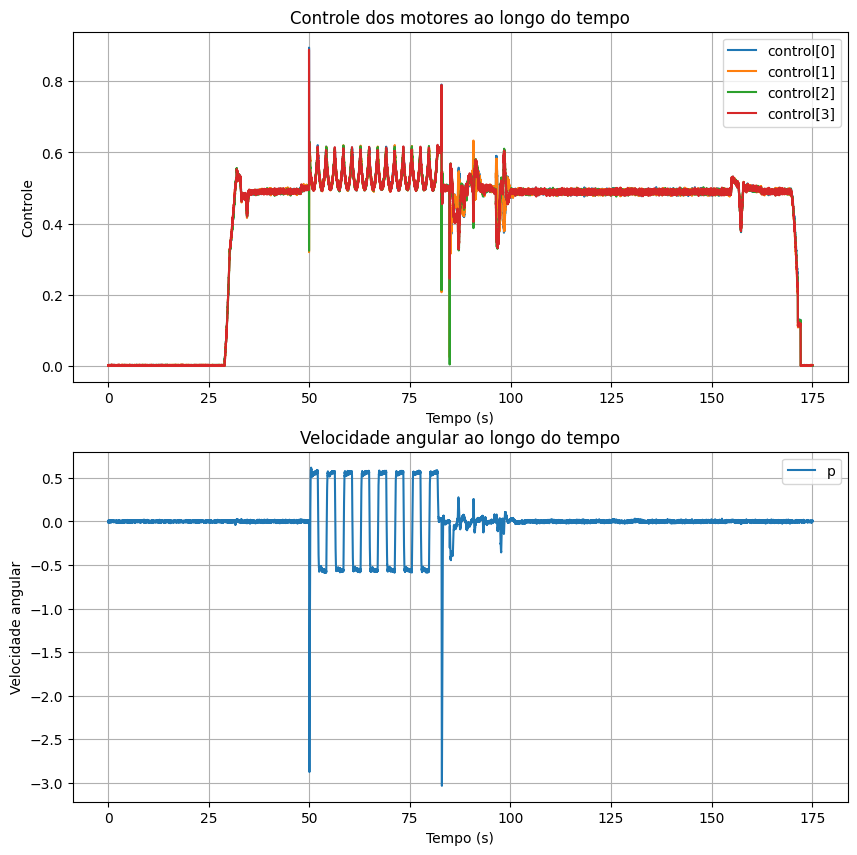

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
#
ax1.plot(t_controle, control0, label='control[0]')
ax1.plot(t_controle, control1, label='control[1]')
ax1.plot(t_controle, control2, label='control[2]')
ax1.plot(t_controle, control3, label='control[3]')
#
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle dos motores ao longo do tempo')
ax1.legend()
ax1.grid()
#
ax2.plot(t_taxas, vav0, label='p')
#
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular')
ax2.set_title('Velocidade angular ao longo do tempo')
ax2.legend()
ax2.grid()
#
#plt.tight_layout()
plt.show()
#  

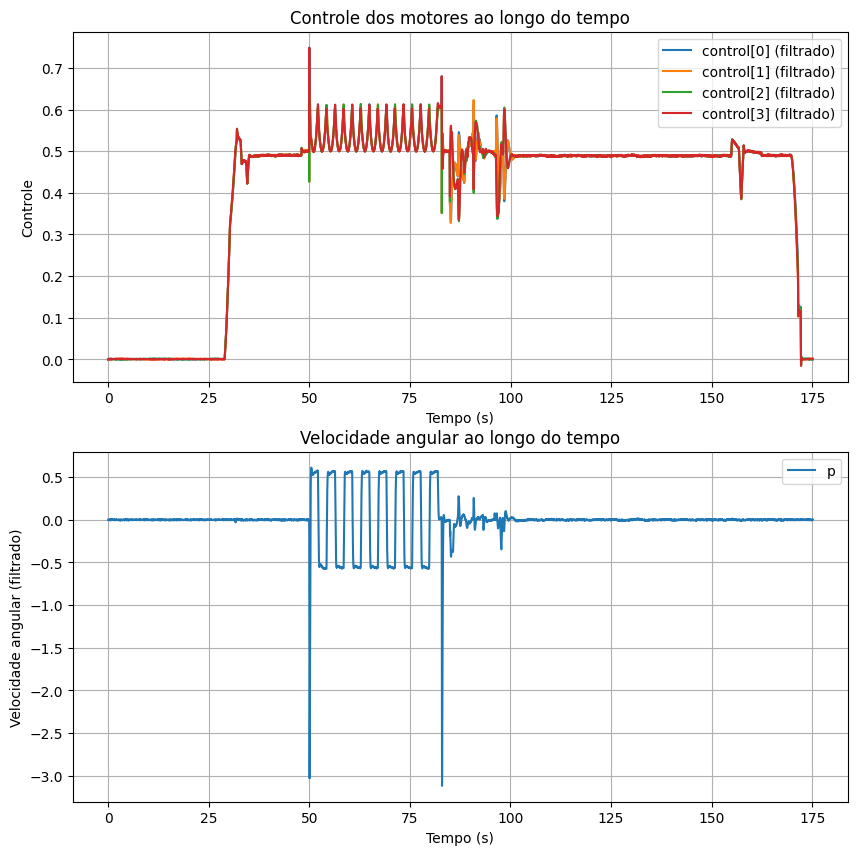

In [8]:
# filtrar o sinal de controle
fc = 10  # Frequência de corte
control0_filtrado = butter_lowpass_filter(control0, fc, 1/dt_controle)
control1_filtrado = butter_lowpass_filter(control1, fc, 1/dt_controle)
control2_filtrado = butter_lowpass_filter(control2, fc, 1/dt_controle)
control3_filtrado = butter_lowpass_filter(control3, fc, 1/dt_controle)
#
# filtrar as derivadas dos controles
#dcontrol0_filtrado = butter_lowpass_filter(dcontrole0, fc, 1/dt_controle)
#dcontrol1_filtrado = butter_lowpass_filter(dcontrole1, fc, 1/dt_controle)
#dcontrol2_filtrado = butter_lowpass_filter(dcontrole2, fc, 1/dt_controle)
#dcontrol3_filtrado = butter_lowpass_filter(dcontrole3, fc, 1/dt_controle)
#
# filtrar o sinal de velocidade angular
vav0_filtrado = butter_lowpass_filter(vav0, fc, 1/dt_taxas)
# Plotar os sinais filtrados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
#
ax1.plot(t_controle, control0_filtrado, label='control[0] (filtrado)')
ax1.plot(t_controle, control1_filtrado, label='control[1] (filtrado)')
ax1.plot(t_controle, control2_filtrado, label='control[2] (filtrado)')
ax1.plot(t_controle, control3_filtrado, label='control[3] (filtrado)')
#
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle dos motores ao longo do tempo')
ax1.legend()
ax1.grid()
#
ax2.plot(t_taxas, vav0_filtrado, label='p')
#
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular (filtrado)')
ax2.set_title('Velocidade angular ao longo do tempo')
ax2.legend()
ax2.grid()
#
#plt.tight_layout()
plt.show()


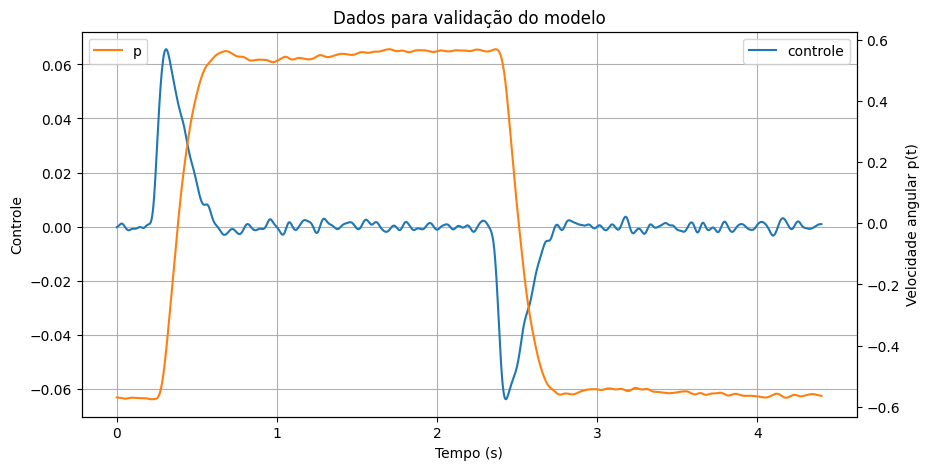

In [9]:
# Recortando os dados para análise
t0 = 54.0
t1 = 58.4 #80.0
idx0 = int(t0/dt_controle)
idx1 = int(t1/dt_controle)
control0_rec = control0_filtrado[idx0:idx1]
control1_rec = control1_filtrado[idx0:idx1]
control2_rec = control2_filtrado[idx0:idx1]
control3_rec = control3_filtrado[idx0:idx1]
t_controle_rec = t_controle[idx0:idx1]

# Essa operação também remove a média dos sinais de controle. Cuidado.
controle = control1_rec + control2_rec - control0_rec - control3_rec

#
idx0 = int(t0/dt_taxas)
idx1 = int(t1/dt_taxas)
taxa_p = vav0_filtrado[idx0:idx1]
t_taxas_rec = t_taxas[idx0:idx1]
#
# tempo de amostragem
dt = t_controle_rec[1] - t_controle_rec[0]
tempo = np.linspace(0, len(controle)*dt, len(controle))
#
fig, ax1 = plt.subplots(figsize=(10, 5))
#
#ax1.plot(t_controle_rec, controle, label='controle', color='tab:blue')
ax1.plot(tempo, controle, label='controle', color='tab:blue')
#ax1.plot(tempo, dcontrole, label='dcontrole', color='tab:red')
#
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Dados para validação do modelo')
#ax1.set_xlim([t0, 58])
ax1.legend(loc='upper right')
ax1.grid()
#
ax2 = ax1.twinx()
#ax2.plot(t_taxas_rec, vav0_rec, label='p', color='tab:orange')
ax2.plot(tempo, taxa_p, label='p', color='tab:orange')
#
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular p(t)')
#ax2.set_title('Velocidade angular ao longo do tempo')
#ax2.set_xlim([t0, 58])
ax2.legend(loc='upper left')
#ax2.grid()
#
#plt.tight_layout()
plt.show()

# Ajuste de parâmetros

Aplicamos o método dos mínimos quadrados para ajustar os parâmetros do modelo para representar o melhor possível os dados obtido a partir do experimento.

Passos:
1. Preparar o sinal de entrada.
2. Preparar a ODE que representa o modelo.
3. Escolher os valores mínimos e máximos dos parâmetros e o chute inicial.
4. Ajustar os parãmetros do ajuste
5. Rodar o ajuste.
6. Verificar o resultado por comparação.
---

1. Preparar o sinal de entrada $\hat{u}(t)=\dfrac{k}{aI_{xx}}(\dot{u}(t-\tau)+\dfrac{1}{T}u(t-\tau))$.

In [10]:
# calcula a derivada do sinal de controle
dt = tempo[1] - tempo[0]
dcontrole = np.gradient(controle, dt)
# filtrar a derivada do sinal de controle
fc = 5 # (Hz) frequência de corte da derivada do sinal de controle
dcontrole_filt = butter_lowpass_filter(dcontrole, fc, 1/dt)

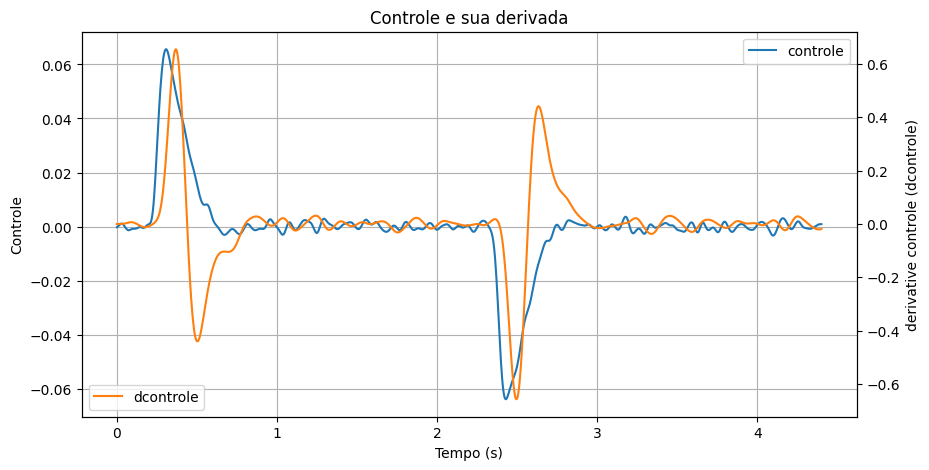

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(tempo, controle, label='controle', color='tab:blue')
#
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle e sua derivada')
ax1.legend(loc='upper right')
ax1.grid()
#
ax2 = ax1.twinx()
ax2.plot(tempo, dcontrole_filt, label='dcontrole', color='tab:orange')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('derivative controle (dcontrole)')
ax2.legend(loc='lower left')
plt.show()

In [12]:
# interpolação do sinal de controle
controle_interp = interp1d(tempo, controle, kind='linear', fill_value='extrapolate')
dcontrole_interp = interp1d(tempo, dcontrole_filt, kind='linear', fill_value='extrapolate')
# 
# Sinal de controle u_hat(t)
def u_hat(t, tau, k, a, Ixx):
    return (k/(a*Ixx))*(dcontrole_interp(t-tau) + (1/T)*controle_interp(t-tau))

2. Preparar a ODE que representa o modelo.
$$
\begin{align*}
\dot{x}_1&=x_2\\
\dot{x}_2&=-\dfrac{1}{aT}x_2+\hat{u}.
\end{align*}
$$

In [13]:
# definição da ODE
def ode(t, x, tau, k, a, Ixx):
    dx = np.zeros(2)
    dx[0] = x[1]
    dx[1] = -(1/(a*T))*x[1] + u_hat(t, tau, k, a, Ixx) 
    return dx

3. Escolher os valores mínimos e máximos dos parâmetros $I_{xx}$, $\tau$, $T$, $k$ e $a$.

In [14]:
phim_min = 1.0  # Avanço de fase mínimo    
phim_max = 10.0 # Avanço de fase máximo
Gc_min = 1.0    # Ganho mínimo
Gc_max = 5.0    # Ganho máximo
fm_min = 0.05   # Frequência média mínima (Hz)
fm_max = 1.0    # Frequência média máxima (Hz)

a1, T1, k1 = calcula_param_comp(fm_min, Gc_min, phim_min)
a2, T2, k2 = calcula_param_comp(fm_max, Gc_max, phim_max)

T_min = min(T1, T2) 
T_max = max(T1, T2)
k_min = min(k1, k2)
k_max = max(k1, k2) 
a_min = min(a1, a2)
a_max = max(a1, a2)

Ixx_min = 1/120
Ixx_max = 1/50
tau_min = 0.009
tau_max = 0.025

param_min = [Ixx_min, tau_min, T_min, k_min, a_min]
param_max = [Ixx_max, tau_max, T_max, k_max, a_max]
# 
# Parâmetros iniciais
Ixx_0 = uniform(Ixx_min, Ixx_max)
tau_0 = uniform(tau_min, tau_max)
T_0 = uniform(T_min, T_max)
k_0 = uniform(k_min, k_max)
a_0 = uniform(a_min, a_max)
#
p0 = [Ixx_0, tau_0, T_0, k_0, a_0]

In [20]:
f = lambda t, x: ode(t, x, tau_0, k_0, a_0, Ixx_0)
x0 = np.array([0, 0])
t0 = tempo[0]
tf = tempo[-1] 
h = dt 
t, x =  rk4(f, x0, t0, tf, h)